In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
from google.colab import files

# List of stock symbols
sample_stocks = [
    "HEROMOTOCO.NS", "TITAN.NS"
]

# Define the time range
start_date = "2006-01-01"
end_date = "2023-01-01"

# Fetch historical data
data = yf.download(sample_stocks, start=start_date, end=end_date)['Close']

# Backward-fill missing values with the last available value
data.bfill(inplace=True)

# Save the data to a CSV file
data.to_csv('/content/samplestocks_closing_prices_bfill.csv')

# Download the file within Colab
#files.download('/content/samplestocks_closing_prices_bfill.csv')


[*********************100%%**********************]  2 of 2 completed


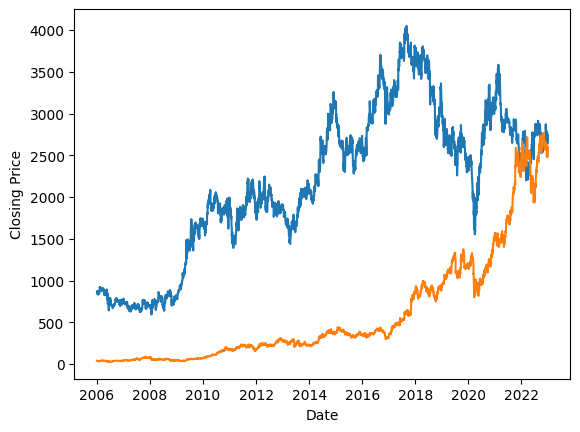

In [ ]:
import matplotlib.pylab as plt

plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.plot(data)

In [ ]:
data_rows, data_columns = data.shape


In [ ]:
#function to compute asset returns
def StockReturnsComputing(StockPrice, Rows, Columns):

    import numpy as np

    StockReturn = np.zeros([Rows-1, Columns])
    for j in range(Columns):        # j: Assets
        for i in range(Rows-1):     # i: Daily Prices
            StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

    return StockReturn

In [ ]:
import numpy as np

stockPriceArray = np.asarray(data)
[Rows, Cols]=stockPriceArray.shape
stockReturns = StockReturnsComputing(stockPriceArray, Rows, Cols)
print('Daily returns of selective sample stocks\n', stockReturns)

Daily returns of selective sample stocks
 [[ 1.79057143 -0.0299013 ]
 [-0.53410457  2.86864544]
 [ 1.31909035 -5.98432716]
 ...
 [-0.21277776  3.05964938]
 [ 0.94933815 -1.0425713 ]
 [ 0.61164304  1.73308528]]


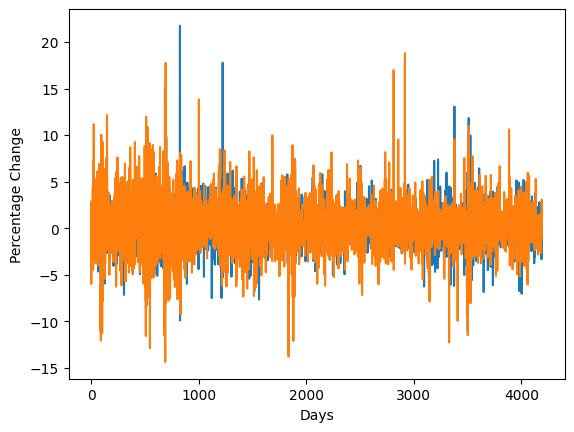

In [ ]:
plt.xlabel("Days")
plt.ylabel("Percentage Change")
plt.plot(stockReturns)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

columns_data = {}

for col in range(Cols):
  DatatoPredict = [sublist[col] for sublist in stockReturns]
  model = ARIMA(DatatoPredict,order=(2,2,2))
  result_ARIMA = model.fit()

  columns_data[col] = result_ARIMA.forecast(steps=252)
  #252 number of trading days in a calendar year

DataGeneratedByTimeSeriesAnalysis = pd.DataFrame(columns_data)

# Display the DataFrame
print(DataGeneratedByTimeSeriesAnalysis)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


            0         1
0   -0.024830 -0.233313
1   -0.011412 -0.173672
2    0.023317 -0.196655
3    0.022904 -0.193350
4    0.021058 -0.191380
..        ...       ...
247  0.031473  0.366844
248  0.031515  0.369141
249  0.031558  0.371438
250  0.031600  0.373736
251  0.031642  0.376033

[252 rows x 2 columns]


In [ ]:
[Generated_Rows, Generated_Cols]=DataGeneratedByTimeSeriesAnalysis.shape

In [ ]:
meanReturns = np.mean(stockReturns, axis = 0)
print('Mean returns of sample Stocks:\n',  meanReturns)
covReturns = np.cov(stockReturns, rowvar=False)
print('Variance-covariance matrix of returns of sample Stocks:\n')
print(covReturns)

GeneratedStockReturns = np.asarray(DataGeneratedByTimeSeriesAnalysis)
GeneratedmeanReturns = np.mean(GeneratedStockReturns, axis = 0)
print('Mean returns of forecasted data:\n',  GeneratedmeanReturns)
GeneratedcovReturns = np.cov(GeneratedStockReturns, rowvar=False)
print('Variance-covariance matrix of returns of forecasted data:\n')
print(GeneratedcovReturns)


Mean returns of sample Stocks:
 [0.04702897 0.12933651]
Variance-covariance matrix of returns of sample Stocks:

[[3.82916379 1.2252536 ]
 [1.2252536  5.9883011 ]]
Mean returns of forecasted data:
 [0.02602395 0.08770405]
Variance-covariance matrix of returns of forecasted data:

[[2.52151630e-05 6.05936892e-04]
 [6.05936892e-04 2.80634047e-02]]


In [ ]:
#function obtains maximal return portfolio using linear programming

def MaximizeReturns(MeanReturns, PortfolioSize):

    #dependencies
    from scipy.optimize import linprog
    import numpy as np

    c = (np.multiply(-1, MeanReturns))
    A = np.ones([PortfolioSize,1]).T
    b=[1]
    res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex')

    return res

In [ ]:
#Maximal expected portfolio return computation for the portfolio
result1 = MaximizeReturns(meanReturns, data_columns)
maxReturnWeights = result1.x
print("The solution for the weights are")
print(maxReturnWeights)
maxExpPortfolioReturn = np.matmul(meanReturns.T, maxReturnWeights)
print("Maximal Expected Portfolio Return:   %7.4f" % maxExpPortfolioReturn )

Generatedresult1 = MaximizeReturns(GeneratedmeanReturns, Generated_Cols)
GeneratedmaxReturnWeights = Generatedresult1.x
print("The solution for the weights are")
print(GeneratedmaxReturnWeights)
GeneratedmaxExpPortfolioReturn = np.matmul(GeneratedmeanReturns.T, GeneratedmaxReturnWeights)
print("Maximal Expected Portfolio Return:   %7.4f" % GeneratedmaxExpPortfolioReturn )

The solution for the weights are
[0. 1.]
Maximal Expected Portfolio Return:    0.1293
The solution for the weights are
[0. 1.]
Maximal Expected Portfolio Return:    0.0877


<ipython-input-11-6129d2bdd2e0>:12: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = linprog(c, A_ub = A, b_ub = b, bounds = (0,1), method = 'simplex')


In [ ]:
#function obtains minimal risk portfolio

#dependencies
import numpy as np
from scipy import optimize

def MinimizeRisk(CovarReturns, PortfolioSize):

    def  f(x, CovarReturns):
        func = np.matmul(np.matmul(x, CovarReturns), x.T)
        return func

    def constraintEq(x):
        A=np.ones(x.shape)
        b=1
        constraintVal = np.matmul(A,x.T)-b
        return constraintVal

    xinit=np.repeat(0.1, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq})
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = optimize.minimize (f, x0 = xinit, args = (CovarReturns),  bounds = bnds, \
                             constraints = cons, tol = 10**-3)

    return opt

In [ ]:
result2 = MinimizeRisk(covReturns, data_columns)
minRiskWeights = result2.x
print("The solution for the weights are")
print(minRiskWeights)
minRiskExpPortfolioReturn = np.matmul(meanReturns.T, minRiskWeights)
print("Expected Return of Minimum Risk Portfolio:  %7.4f" % minRiskExpPortfolioReturn)

Generatedresult2 = MinimizeRisk(GeneratedcovReturns, Generated_Cols)
GeneratedminRiskWeights = Generatedresult2.x
print("The solution for the weights are")
print(GeneratedminRiskWeights)
GeneratedminRiskExpPortfolioReturn = np.matmul(GeneratedmeanReturns.T, GeneratedminRiskWeights)
print("Expected Return of Minimum Risk Portfolio:  %7.4f" % GeneratedminRiskExpPortfolioReturn)

The solution for the weights are
[0.64691982 0.35308018]
Expected Return of Minimum Risk Portfolio:   0.0761
The solution for the weights are
[0.50280382 0.49719618]
Expected Return of Minimum Risk Portfolio:   0.0567


In [ ]:
#function obtains Minimal risk and Maximum return portfolios

#dependencies
import numpy as np
from scipy import optimize

def MinimizeRiskConstr(MeanReturns, CovarReturns, PortfolioSize, R):

    def  f(x,CovarReturns):

        func = np.matmul(np.matmul(x,CovarReturns ), x.T)
        return func

    def constraintEq(x):
        AEq=np.ones(x.shape)
        bEq=1
        EqconstraintVal = np.matmul(AEq,x.T)-bEq
        return EqconstraintVal

    def constraintIneq(x, MeanReturns, R):
        AIneq = np.array(MeanReturns)
        bIneq = R
        IneqconstraintVal = np.matmul(AIneq,x.T) - bIneq
        return IneqconstraintVal


    xinit=np.repeat(0.1, PortfolioSize)
    cons = ({'type': 'eq', 'fun':constraintEq},
            {'type':'ineq', 'fun':constraintIneq, 'args':(MeanReturns,R) })
    lb = 0
    ub = 1
    bnds = tuple([(lb,ub) for x in xinit])

    opt = optimize.minimize (f, args = (CovarReturns), method ='trust-constr',  \
                        x0 = xinit,   bounds = bnds, constraints = cons, tol = 10**-3)

    return  opt

In [ ]:
#compute efficient set for the maximum return and minimum risk portfolios
#increment = 0.001
increment = 0.01
low = minRiskExpPortfolioReturn
high = maxExpPortfolioReturn

#initialize optimal weight set and risk-return point set
xOptimal =[]
minRiskPoint = []
expPortfolioReturnPoint =[]

#repeated execution of function MinimizeRiskConstr to determine the efficient set
while (low < high):

    result3 = MinimizeRiskConstr(meanReturns, covReturns, data_columns, low)
    xOptimal.append(result3.x)
    expPortfolioReturnPoint.append(low)
    low = low+increment

#gather optimal weight set
xOptimalArray = np.array(xOptimal)

#obtain annualized risk for the efficient set portfolios
#for trading days = 252
minRiskPoint = np.diagonal(np.matmul((np.matmul(xOptimalArray,covReturns)),\
                                     np.transpose(xOptimalArray)))
riskPoint =   np.sqrt(minRiskPoint*252)

#obtain expected portfolio annualized return for the
#efficient set portfolios, for trading days = 252
retPoint = 252*np.array(expPortfolioReturnPoint)

#display efficient set portfolio parameters
print("Size of the  efficient set:", xOptimalArray.shape )
print("Optimal weights of the efficient set portfolios: \n", xOptimalArray)
print("Annualized Risk and Return of the efficient set portfolios: \n", \
                                                np.c_[riskPoint, retPoint])

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Size of the  efficient set: (6, 2)
Optimal weights of the efficient set portfolios: 
 [[0.6418583  0.35804326]
 [0.52526586 0.47473414]
 [0.40361994 0.59638006]
 [0.28156822 0.71843178]
 [0.16085484 0.83914516]
 [0.04632925 0.95368317]]
Annualized Risk and Return of the efficient set portfolios: 
 [[27.07232186 19.17471351]
 [27.57390304 21.69471351]
 [29.02701981 24.21471351]
 [31.30987737 26.73471351]
 [34.21903759 29.25471351]
 [37.4413653  31.77471351]]


In [ ]:
#compute efficient set for the maximum return and minimum risk portfolios
#increment = 0.001
increment = 0.01
low = GeneratedminRiskExpPortfolioReturn
high = GeneratedmaxExpPortfolioReturn

#initialize optimal weight set and risk-return point set
GeneratedxOptimal =[]
GeneratedminRiskPoint = []
GeneratedexpPortfolioReturnPoint =[]

#repeated execution of function MinimizeRiskConstr to determine the efficient set
while (low < high):

    Generatedresult3 = MinimizeRiskConstr(GeneratedmeanReturns, GeneratedcovReturns, Generated_Cols, low)
    GeneratedxOptimal.append(Generatedresult3.x)
    GeneratedexpPortfolioReturnPoint.append(low)
    low = low+increment

#gather optimal weight set
GeneratedxOptimalArray = np.array(GeneratedxOptimal)

#obtain annualized risk for the efficient set portfolios
#for trading days = 252
GeneratedminRiskPoint = np.diagonal(np.matmul((np.matmul(GeneratedxOptimalArray,GeneratedcovReturns)),\
                                     np.transpose(GeneratedxOptimalArray)))
GeneratedriskPoint =   np.sqrt(GeneratedminRiskPoint*252)

#obtain expected portfolio annualized return for the
#efficient set portfolios, for trading days = 252
GeneratedretPoint = 252*np.array(GeneratedexpPortfolioReturnPoint)

#display efficient set portfolio parameters
print("Size of the  efficient set:", GeneratedxOptimalArray.shape )
print("Optimal weights of the efficient set portfolios: \n", GeneratedxOptimalArray)
print("Annualized Risk and Return of the efficient set portfolios: \n", \
                                                np.c_[GeneratedriskPoint, GeneratedretPoint])

Size of the  efficient set: (4, 2)
Optimal weights of the efficient set portfolios: 
 [[0.41158594 0.58822747]
 [0.28731898 0.71268102]
 [0.12923434 0.87076566]
 [0.01270392 0.98729385]]
Annualized Risk and Return of the efficient set portfolios: 
 [[ 1.58808057 14.28614728]
 [ 1.91180988 16.80614728]
 [ 2.32307526 19.32614728]
 [ 2.62625893 21.84614728]]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [ ]:
UserExpectedReturn = 21.0
def find_closest_element_index(arr, target_value):
    # Calculate the absolute differences between each element and the target value
    differences = np.abs(arr - target_value)

    # Find the index of the minimum difference
    index_of_closest_element = np.argmin(differences)

    return index_of_closest_element

StatisticsWiseClosestindex = find_closest_element_index(retPoint,UserExpectedReturn)
DataScienceWiseClosestindex = find_closest_element_index(GeneratedretPoint,UserExpectedReturn)

print('weightage suggested by Statistics')
print(xOptimalArray[StatisticsWiseClosestindex])
print('weightage suggested by Data Science and Statistics')
print(GeneratedxOptimalArray[DataScienceWiseClosestindex])


weightage suggested by Statistics
[0.52526586 0.47473414]
weightage suggested by Data Science and Statistics
[0.01270392 0.98729385]


[0.21010634 0.18989366]
[0.00508157 0.39491754]
[0.1 0.1]
Final Portfolio
[0.31518791 0.6848112 ]


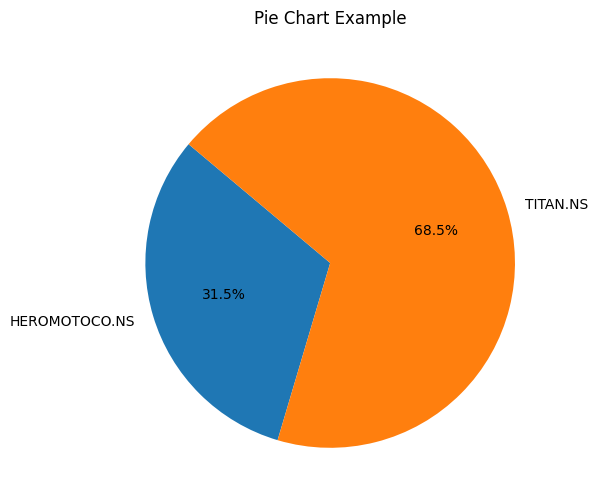

In [ ]:
PortfolioByUserintuition = np.array([0.5,0.5])

UserConfidenceOnStatisticsBasedPortfolio = 0.4
UserConfidenceOnDataScienceBasedPortfolio = 0.4
UserConfidenceOnIntuitionBasedPortfolio = 0.2
#Sum of all Confidence should be equal to 1.0

AdjustedStatisticsBasedPortfolio = xOptimalArray[StatisticsWiseClosestindex]*UserConfidenceOnStatisticsBasedPortfolio
AdjustedDataScienceBasedPortfolio = GeneratedxOptimalArray[DataScienceWiseClosestindex]*UserConfidenceOnDataScienceBasedPortfolio
AdjustedUserIntuitionBasedPortfolio = PortfolioByUserintuition*UserConfidenceOnIntuitionBasedPortfolio

print(AdjustedStatisticsBasedPortfolio)
print(AdjustedDataScienceBasedPortfolio)
print(AdjustedUserIntuitionBasedPortfolio)

PortfolioWeightates=[AdjustedStatisticsBasedPortfolio,AdjustedDataScienceBasedPortfolio,AdjustedUserIntuitionBasedPortfolio]

FinalPortfolio = np.zeros_like(AdjustedUserIntuitionBasedPortfolio)

for arr in PortfolioWeightates:
    FinalPortfolio += arr

print('Final Portfolio')

print(FinalPortfolio)

# Create a pie chart
plt.figure(figsize=(6, 6))  # Set the figure size
plt.pie(FinalPortfolio, labels=sample_stocks, autopct='%1.1f%%', startangle=140)

# Add a title
plt.title('Pie Chart Example')

# Display the pie chart
plt.show()

